In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

In [30]:
from sklearn.metrics import roc_curve,auc
from matplotlib import pyplot

In [43]:
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
#pd.options.mode.chained_assignment = None
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb

In [95]:
from sklearn.model_selection import KFold,StratifiedKFold

In [3]:
from etl import get_to_know_data,plot1,data_clean,do_pca,scree_plot_1,scree_plot_2,model_kmeans,build_roc_auc

# Part 0: Data EDA 

In [7]:
azdias=pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')

C:\Users\Xue Wang\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [8]:
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [9]:
# As the information from the description, there are three extra columns from the CUSTOMERS file, which don't need
customers=customers.drop(['CUSTOMER_GROUP','ONLINE_PURCHASE','PRODUCT_GROUP'],axis=1)

In [8]:
get_to_know_data(azdias)

shape: (891221, 366)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB
info: None

Thers is 0 duplicated records


In [9]:
%%time
get_to_know_data(customers)

shape: (191652, 366)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 535.2+ MB
info: None

Thers is 0 duplicated records
Wall time: 7.58 s


null value percentage description:        percentage
count  366.000000
mean     0.102680
std      0.121640
min      0.000000
25%      0.000000
50%      0.118714
75%      0.120230
max      0.998648
Wall time: 7.82 s


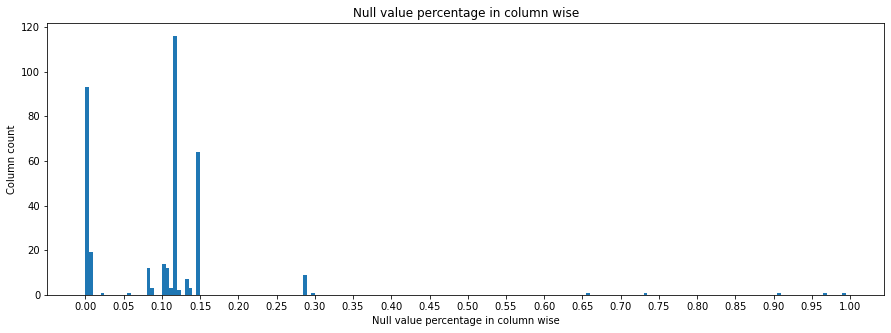

In [12]:
%%time
plot1(azdias)

null value percentage description:        percentage
count  366.000000
mean     0.197656
std      0.151007
min      0.000000
25%      0.000000
50%      0.267574
75%      0.267574
max      0.998769
Wall time: 937 ms


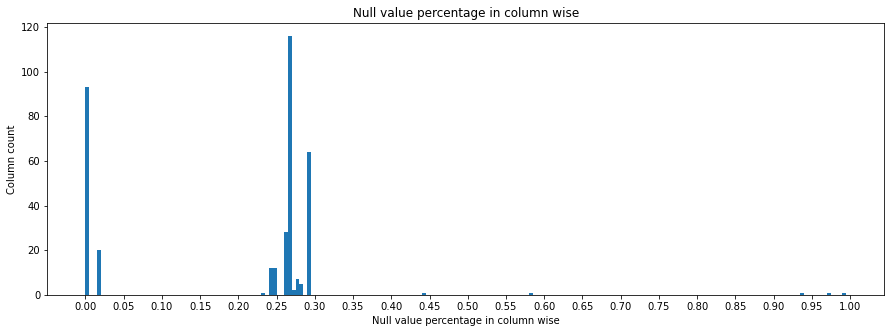

In [13]:
%%time
plot1(customers)

In [4]:
# read the Attributes file
value_17 = pd.read_excel('DIAS Attributes - Values 2017.xlsx',header=None)

In [5]:
def null_attributes_list(val_17):
    '''
    get the unknown values list from the attributes excel file
    input: attributes file as pd
    output: unknown value feature and list 
    '''
    # get the records with col 4 with the value as unknown
    val_17_unknown=val_17[val_17.iloc[:,4].isin(['unknown','unknown / no main age detectable'])]
    # rename the column names
    val_17_unknown=val_17_unknown.rename(columns={1:'feature',2:'fea_dis',3:'null_val'})
    # choose the target two columns
    val_17_unknown=val_17_unknown[['feature','null_val']]
    # reset index
    val_17_unknown.reset_index(drop=True, inplace=True)
    # There are two types of data in null_val one, int and str. In order to be used, they need to be transferred into one format as list
    # The target is to get the same format list, the difficulty is to how to deal with the variable lengthe variable
    val=[]
    for i in val_17_unknown['null_val']:
        if type(i)==int:
            val.append([i]) # if it is int, append it as  a list to val
        if type(i)==str:
            val1=list(map(int, i.split(',')))# if it is a string, first split it, then map them as int, and then save as a list
            val.append(val1) # now append the list to value
    # create a new column to save the val created as above
    val_17_unknown['new']=val
    # save value_2017_null_feature_1 as csv, then don't need to run above codes
    return val_17_unknown
    #val_17_unknown.to_csv('1_value_2017_null_features.csv',index=False)

In [6]:
null_list_attributes_2017=null_attributes_list(value_17)

In [375]:
null_list_attributes_2017.head()

,feature,null_val,new
0,AGER_TYP,-1,[-1]
1,ALTERSKATEGORIE_GROB,"-1, 0","[-1, 0]"
2,ALTER_HH,0,[0]
3,ANREDE_KZ,"-1, 0","[-1, 0]"
4,BALLRAUM,-1,[-1]


In [13]:
df_a=azdias

In [14]:
%%time
azdias_cleaned, azdias_index=data_clean(null_list_attributes_2017,df_a)

Wall time: 1min 21s


In [15]:
df_c=customers

In [16]:
%%time
customers_cleaned,customers_index=data_clean(null_list_attributes_2017,df_c)

Wall time: 13.2 s


# Part 1: Customer Segmentation Report

## PCA

In [17]:
data=azdias_cleaned

In [20]:
%%time
pca_a, X_pca_a = do_pca(358,data)

Wall time: 3min 11s


In [21]:
data.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2.0,1.0,18.0,15.0,1.0,0.0,0.0,1.0,1.0,0.0,...,2.0,10.0,10.0,10.0,6.0,9.0,3.0,3,1,2
1,2.0,9.0,18.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,2.0,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,2.0,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,7.0,10.0,11.0,6.0,9.0,7.0,3,2,4
4,2.0,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [23]:
pca_a

PCA(n_components=358)

Wall time: 836 ms


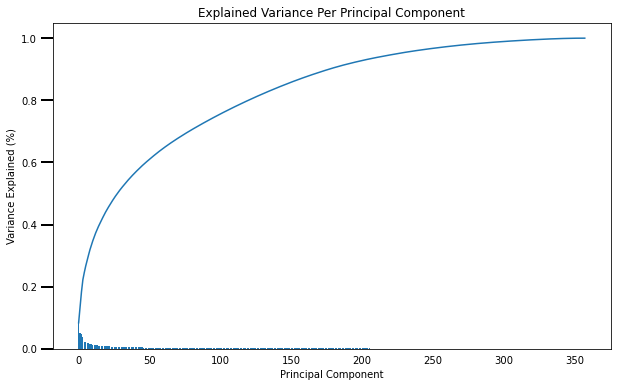

In [24]:
%%time
scree_plot_1(pca_a)

In [25]:
data=azdias_cleaned

In [18]:
%%time
pca_a, X_pca_a = do_pca(15,data )

Wall time: 1min 38s


Wall time: 398 ms


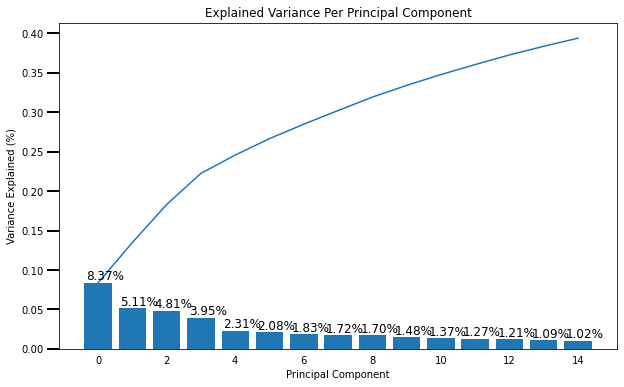

In [19]:
%%time
scree_plot_2(pca_a)

In [ ]:
# below codes to display how the compnents of PCA looks like

Choose n_component=15 to balance the running time and performance

# Find the best K

Wall time: 0 ns


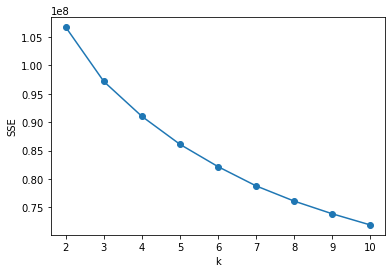

Wall time: 5min 20s


In [27]:
%%time
est=model_kmeans(10, X_pca_a)

In [ ]:
I have tried K =20, but taking one hour without results yet, so I take ks=10 which I think it also makes sense.

In [29]:
ks=10

%%time
k_means = KMeans(init = "k-means++", n_clusters = ks,random_state=42)

Wall time: 0 ns


In [30]:
%%time
# use the best model to fit again
model_k_a=k_means.fit(X_pca_a)

Wall time: 58.9 s


In [31]:
model_k_a.labels_

array([0, 3, 3, ..., 3, 4, 9])

In [ ]:
# now display the pca components

In [356]:
dim_a =['Dimension' +str(i) for i in range(1,len(pca_a.components_)+1)]
comp_dist_a=pd.DataFrame(np.round(pca_a.components_,5),columns=azdias_col)
comp_dist_a.index=dim

In [357]:
comp_dist_a.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
Dimension1,-0.02113,-0.05735,0.00083,-0.00998,-0.06305,-0.01475,0.04180,0.09280,-0.06213,0.00336,...,-0.02776,-0.11607,-0.11362,-0.10051,-0.07583,0.00914,0.04469,-0.07288,-0.00491,0.02245
Dimension2,0.02670,-0.00099,0.06995,0.08966,0.03950,0.00134,0.05934,0.07212,0.03654,-0.00335,...,0.00836,-0.12336,-0.09182,-0.05955,-0.09700,-0.05552,-0.00362,0.04270,0.00262,-0.08120
Dimension3,0.01508,0.01388,0.01485,0.02121,0.03469,0.02862,0.01224,0.01080,0.03252,0.01077,...,0.04648,-0.02483,-0.01045,-0.00266,-0.01910,-0.02453,-0.08170,0.00276,0.00445,-0.02448
Dimension4,-0.06536,-0.05174,-0.14184,-0.14281,0.04815,0.02519,-0.03377,0.02304,0.05025,0.01088,...,0.03103,-0.03841,-0.07569,-0.12031,0.03525,0.03722,-0.02805,-0.04186,-0.01497,0.16314
Dimension5,0.01688,-0.01669,0.02135,0.02816,-0.00540,0.00812,0.00126,-0.01248,-0.00220,0.00264,...,-0.03117,0.00076,-0.01517,-0.00018,0.00338,-0.00276,-0.05840,-0.00356,0.02847,-0.03767


In [359]:
print('Principal Component 0: ')
print('Top 5 features: ')
print(comp_dist_a.iloc[0].sort_values(ascending=False)[:5])
print('Bottom 5 features: ')
print(comp_dist_a.iloc[0].sort_values(ascending=False)[-5:])
print('Variance Explained: ',pca_a.explained_variance_ratio_[0]*100)

Principal Component 0: 
Top 5 features: 
MOBI_RASTER       0.12214
PLZ8_ANTG1        0.12175
KBA13_ANTG1       0.12070
MOBI_REGIO        0.12062
LP_STATUS_GROB    0.11747
Name: Dimension1, dtype: float64
Bottom 5 features: 
VK_DHT4A          -0.11607
CAMEO_INTL_2015   -0.11830
CAMEO_DEUG_2015   -0.12097
PLZ8_ANTG3        -0.12194
KBA13_ANTG3       -0.12207
Name: Dimension1, dtype: float64
Variance Explained:  8.375648631703452


In [20]:
azdias_col=azdias.columns

In [ ]:
# get the cluster labels
a_cluster_1=pd.DataFrame(model_k_a.labels_, columns=['cluster'])  # 0-9,一共10个标签
# combine the cluster and cleaned azdias data
X_full_a=pd.concat([azdias_cleaned,a_cluster],axis=1)

## Use this trained model to predict on X_pca_customer

In [38]:
data_c=customers_cleaned

In [40]:
%%time
pca_c, X_pca_c = do_pca(15,data_c)

Wall time: 16.2 s


In [42]:
%%time
predict_c=model_k_a.predict(X_pca_c)

Wall time: 158 ms


In [43]:
c_cluster=pd.DataFrame(predict_c, columns=['cluster']) 

In [44]:
# combine the cluster and cleaned azdias data
X_full_c=pd.concat([customers_cleaned,c_cluster],axis=1)

# Anlyzing the cluster for AZDIAS and CUSTOMER

In [ ]:
1. Compare the cluster percentage

In [45]:
X_full_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 359 entries, AGER_TYP to cluster
dtypes: float64(268), int32(1), int64(90)
memory usage: 2.4 GB


In [46]:
X_full_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 359 entries, AGER_TYP to cluster
dtypes: float64(268), int32(1), int64(90)
memory usage: 524.2 MB


Analysis the cluster percentage 

In [48]:
df_cluster_percentage_a = (X_full_a.cluster.value_counts()/X_full_a.shape[0]).sort_values(ascending=False).rename_axis('cluster').reset_index(name='percent')

In [49]:
df_cluster_percentage_c = (X_full_c.cluster.value_counts()/X_full_c.shape[0]).sort_values(ascending=False).rename_axis('cluster').reset_index(name='percent')

In [51]:
df_cluster_percentage_c

,cluster,percent
0,1,0.252473
1,9,0.168978
2,3,0.165634
3,6,0.147251
4,5,0.082201
5,8,0.076983
6,2,0.072496
7,4,0.018074
8,0,0.012424
9,7,0.003485


In [52]:
df_cluster_percentage=df_cluster_percentage_c.merge(df_cluster_percentage_a, how='inner', on='cluster')

df_cluster_percentage.columns=['cluster','customer(%)','population(%)']

In [53]:
df_cluster_percentage=df_cluster_percentage.round(2)

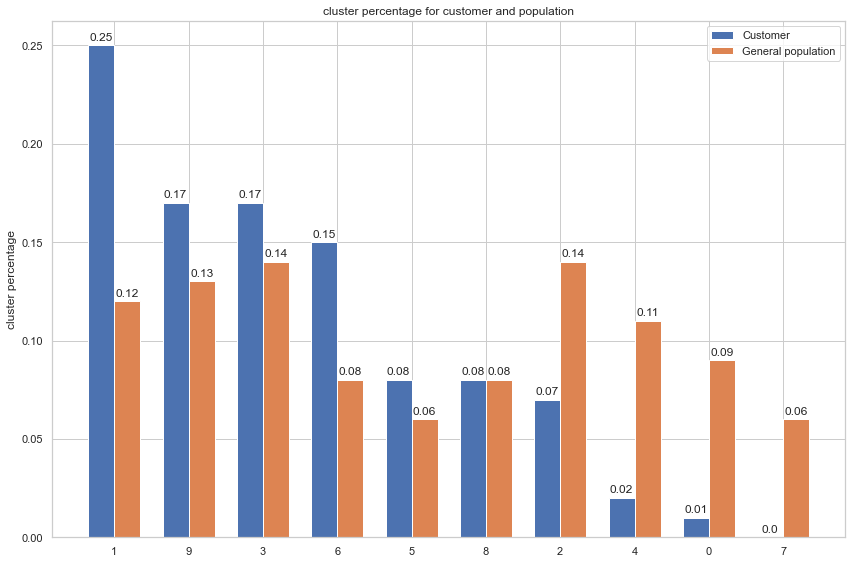

In [374]:
labels =df_cluster_percentage['cluster'] 
customer_percentage = df_cluster_percentage['customer(%)']
population_percentage = df_cluster_percentage['population(%)']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig_dims = (12, 8)
fig, ax = plt.subplots(figsize=fig_dims)
#fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, customer_percentage, width, label='Customer')
rects2 = ax.bar(x + width/2,population_percentage, width, label='General population')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('cluster percentage')
ax.set_title('cluster percentage for customer and population')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


The percentage of clusters 1,9,3,6,5 has increased in customers, which shows the potential to become of customer

Now analysis the cluster combinning with the top features from component 0

In [299]:
X_full_c_1=X_full_c.loc[X_full_c['cluster']==1,['MOBI_RASTER','PLZ8_ANTG1','KBA13_ANTG1','MOBI_REGIO','LP_STATUS_GROB','VK_DHT4A','CAMEO_DEUG_2015','PLZ8_ANTG3','KBA13_ANTG3']]

In [300]:
X_full_a_1=X_full_a.loc[X_full_a['cluster']==1,['MOBI_RASTER','PLZ8_ANTG1','KBA13_ANTG1','MOBI_REGIO','LP_STATUS_GROB','VK_DHT4A','CAMEO_DEUG_2015','PLZ8_ANTG3','KBA13_ANTG3']]

In [301]:
X_full_c_1=X_full_c_1.mean()

In [302]:
X_full_c_1 = pd.Series(X_full_c_1, name="Customers")

In [303]:
X_full_c_1

MOBI_RASTER        1.022299
PLZ8_ANTG1         2.003059
KBA13_ANTG1        2.001922
MOBI_REGIO         4.993366
LP_STATUS_GROB     2.210614
VK_DHT4A           1.108934
CAMEO_DEUG_2015    2.019447
PLZ8_ANTG3         1.004071
KBA13_ANTG3        1.005084
Name: Customers, dtype: float64

In [304]:
X_full_a_1=X_full_a_1.mean()

In [305]:
X_full_a_1 = pd.Series(X_full_a_1, name="General population")

In [306]:
cluster_1 = pd.concat([X_full_c_1, X_full_a_1], axis=1)

In [307]:
cluster_1

,Customers,General population
MOBI_RASTER,1.022299,1.356204
PLZ8_ANTG1,2.003059,1.829278
KBA13_ANTG1,2.001922,1.742122
MOBI_REGIO,4.993366,1.917358
LP_STATUS_GROB,2.210614,1.615016
VK_DHT4A,1.108934,7.808836
CAMEO_DEUG_2015,2.019447,7.142205
PLZ8_ANTG3,1.004071,2.086096
KBA13_ANTG3,1.005084,2.164281


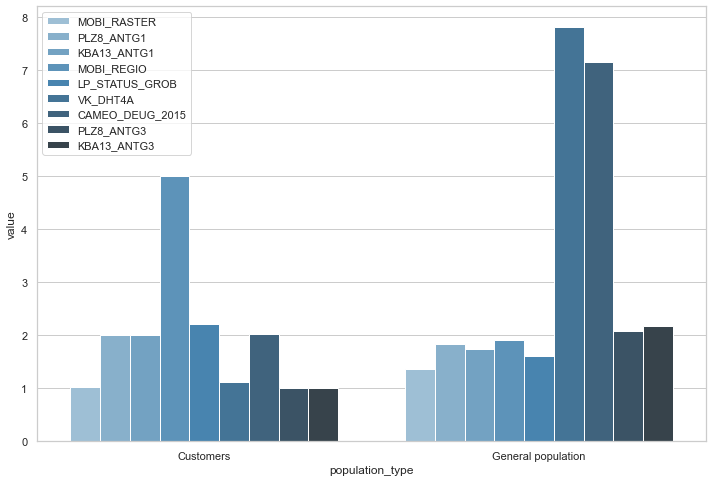

In [308]:
fig_dims = (12, 8)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(x='population_type', y='value', hue='index',ax=ax,palette="Blues_d",
            data=cluster_1.reset_index().melt(id_vars='index', var_name='population_type'))
plt.legend(loc='upper left')


In [314]:
X_full_c_1_cameo=X_full_c.loc[X_full_c['cluster']==1,['CAMEO_INTL_2015']]

In [315]:
X_full_a_1_cameo=X_full_a.loc[X_full_a['cluster']==1,['CAMEO_INTL_2015']]

In [382]:
X_full_c_1_cameo=X_full_c_1_cameo.mean()

In [383]:
X_full_c_1_cameo

14.133775600884535

In [317]:
X_full_c_1_cameo = pd.Series(X_full_c_1_cameo, name="Customers")

In [318]:
X_full_a_1_cameo=X_full_a_1_cameo.mean()

In [384]:
X_full_a_1_cameo

CAMEO_INTL_2015    45.487707
Name: General population, dtype: float64

In [319]:
X_full_a_1_cameo = pd.Series(X_full_a_1_cameo, name="General population")

In [320]:
cluster_1_cameo = pd.concat([X_full_c_1_cameo, X_full_a_1_cameo], axis=1)

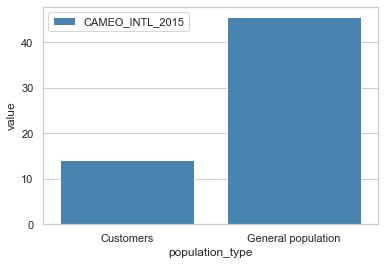

In [323]:
fig_dims = (6, 4)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(x='population_type', y='value', hue='index',ax=ax,palette="Blues_d",
            data=cluster_1_cameo.reset_index().melt(id_vars='index', var_name='population_type'))
plt.legend(loc='upper left')

Now analysis MOBI_RASATER for all clusters

# Part2: Customer labeling

In [7]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

C:\Users\Xue Wang\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
%%time
train_cleaned, train_index=data_clean(null_list_attributes_2017, mailout_train)

Wall time: 3.02 s


In [9]:
y_label = train_cleaned['RESPONSE']
del train_cleaned['RESPONSE']

In [10]:
test_cleaned,test_index=data_clean(null_list_attributes_2017,mailout_test)

In [11]:
# Split the dataset into Train/Validation/Test
X_train, X_test, y_train, y_test = train_test_split(train_cleaned, y_label, test_size=0.2,random_state=42)

In [88]:
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (34369, 358) (34369,)
Test set: (8593, 358) (8593,)


## Ensemble Models

In [44]:
%%time
rf_mod = RandomForestClassifier(n_estimators=1000)

Wall time: 1 ms


In [46]:
%%time
xgb_mod = XGBClassifier(n_estimators=1000, learning_rate=0.001)

Wall time: 1.01 ms


In [48]:
%%time
lgb_mod = lgb.LGBMRegressor(learning_rate=0.001, n_estimators=1000,lambda_l2 = 0.1)

Wall time: 0 ns


In [ ]:

%%time
rf_mod = RandomForestClassifier(n_estimators=1000)
xgb_mod = XGBClassifier((n_estimators=1000, learning_rate=0.001,))
lgb_mod = lgb.LGBMClassifier(learning_rate=0.001, n_estimators=1000,lambda_l2 = 0.1)

## Ensemble model

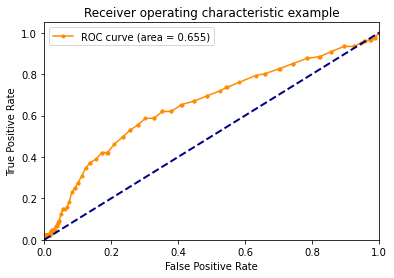

ROC curve (area = 0.66)
roc_auc_score is 0.66
Wall time: 2min 46s


In [89]:
%%time
roc_auc_score_rfc=build_roc_auc(rf_mod, X_train, X_test, y_train, y_test) 

C:\Users\Xue Wang\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:00:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


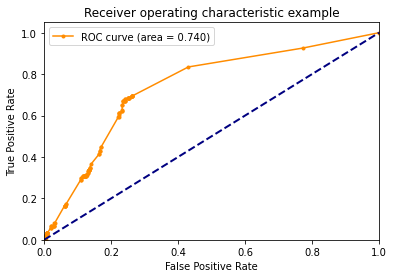

ROC curve (area = 0.74)
roc_auc_score is 0.74
Wall time: 3min 58s


In [90]:
%%time
roc_auc_score_xgb=build_roc_auc(xgb_mod , X_train, X_test, y_train, y_test) 

[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


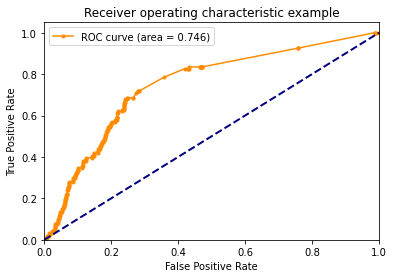

ROC curve (area = 0.75)
roc_auc_score is 0.75
Wall time: 49.9 s


In [91]:
%%time
roc_auc_score_lgb=build_roc_auc(lgb_mod , X_train, X_test, y_train, y_test) 

In [93]:
print('the roc_auc_score of rfc  is {}'.format(roc_auc_score_rfc))
print('the roc_auc_score of xgb  is {}'.format(roc_auc_score_xgb))
print('the roc_auc_score of lgm  is {}'.format(roc_auc_score_lgb))

the roc_auc_score of rfc  is 0.66
the roc_auc_score of xgb  is 0.74
the roc_auc_score of lgm  is 0.75


Compare the three estimators, LGBMClassifier has the best score and the less wall time, so choose this one for gridsearch

## Tuning the model with GridsearchCV

In [115]:
%%time
skf = StratifiedKFold(n_splits=5,random_state=42)
clf = lgb.LGBMClassifier(random_state=42)
parameters = {'learning_rate' : [0.01, 0.001],'n_estimators' : [500, 1000,2000]}
gridsearch = GridSearchCV(clf, parameters, scoring = 'roc_auc',cv=skf, verbose=30)

Wall time: 1 ms


C:\Users\Xue Wang\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [116]:
%%time
gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] learning_rate=0.01, n_estimators=500 ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.01, n_estimators=500, score=0.801, total=  14.1s
[CV] learning_rate=0.01, n_estimators=500 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.0s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=500, score=0.702, total=  16.8s
[CV] learning_rate=0.01, n_estimators=500 ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   30.9s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=500, score=0.734, total=  15.3s
[CV] learning_rate=0.01, n_estimators=500 ............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   46.3s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=500, score=0.730, total=  13.7s
[CV] learning_rate=0.01, n_estimators=500 ............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.0min remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=500, score=0.746, total=  17.7s
[CV] learning_rate=0.01, n_estimators=1000 ...........................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=1000, score=0.774, total=  42.7s
[CV] learning_rate=0.01, n_estimators=1000 ...........................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.0min remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=1000, score=0.672, total=  27.2s
[CV] learning_rate=0.01, n_estimators=1000 ...........................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.5min remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=1000, score=0.710, total=  28.1s
[CV] learning_rate=0.01, n_estimators=1000 ...........................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.9min remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=1000, score=0.721, total=  31.9s
[CV] learning_rate=0.01, n_estimators=1000 ...........................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.5min remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=1000, score=0.718, total=  33.4s
[CV] learning_rate=0.01, n_estimators=2000 ...........................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.0min remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=2000, score=0.741, total=  54.4s
[CV] learning_rate=0.01, n_estimators=2000 ...........................


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:  4.9min remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=2000, score=0.654, total=  56.3s
[CV] learning_rate=0.01, n_estimators=2000 ...........................


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  5.9min remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=2000, score=0.693, total=  57.1s
[CV] learning_rate=0.01, n_estimators=2000 ...........................


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:  6.8min remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=2000, score=0.692, total=  50.3s
[CV] learning_rate=0.01, n_estimators=2000 ...........................


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:  7.7min remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=2000, score=0.695, total=  49.0s
[CV] learning_rate=0.001, n_estimators=500 ...........................


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  8.5min remaining:    0.0s


[CV]  learning_rate=0.001, n_estimators=500, score=0.812, total=  13.2s
[CV] learning_rate=0.001, n_estimators=500 ...........................


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  8.7min remaining:    0.0s


[CV]  learning_rate=0.001, n_estimators=500, score=0.740, total=  13.3s
[CV] learning_rate=0.001, n_estimators=500 ...........................


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:  8.9min remaining:    0.0s


[CV]  learning_rate=0.001, n_estimators=500, score=0.754, total=  13.3s
[CV] learning_rate=0.001, n_estimators=500 ...........................


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  9.1min remaining:    0.0s


[CV]  learning_rate=0.001, n_estimators=500, score=0.770, total=  14.2s
[CV] learning_rate=0.001, n_estimators=500 ...........................


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:  9.4min remaining:    0.0s


[CV]  learning_rate=0.001, n_estimators=500, score=0.762, total=  13.4s
[CV] learning_rate=0.001, n_estimators=1000 ..........................


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  9.6min remaining:    0.0s


[CV]  learning_rate=0.001, n_estimators=1000, score=0.804, total=  25.6s
[CV] learning_rate=0.001, n_estimators=1000 ..........................


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 10.0min remaining:    0.0s


[CV]  learning_rate=0.001, n_estimators=1000, score=0.739, total=  26.0s
[CV] learning_rate=0.001, n_estimators=1000 ..........................


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed: 10.5min remaining:    0.0s


[CV]  learning_rate=0.001, n_estimators=1000, score=0.760, total=  25.1s
[CV] learning_rate=0.001, n_estimators=1000 ..........................


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed: 10.9min remaining:    0.0s


[CV]  learning_rate=0.001, n_estimators=1000, score=0.770, total=  25.2s
[CV] learning_rate=0.001, n_estimators=1000 ..........................


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 11.3min remaining:    0.0s


[CV]  learning_rate=0.001, n_estimators=1000, score=0.758, total=  27.5s
[CV] learning_rate=0.001, n_estimators=2000 ..........................


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 11.8min remaining:    0.0s


[CV]  learning_rate=0.001, n_estimators=2000, score=0.801, total=  56.3s
[CV] learning_rate=0.001, n_estimators=2000 ..........................


[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed: 12.7min remaining:    0.0s


[CV]  learning_rate=0.001, n_estimators=2000, score=0.743, total=  55.1s
[CV] learning_rate=0.001, n_estimators=2000 ..........................


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 13.6min remaining:    0.0s


[CV]  learning_rate=0.001, n_estimators=2000, score=0.753, total=  48.8s
[CV] learning_rate=0.001, n_estimators=2000 ..........................


[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed: 14.4min remaining:    0.0s


[CV]  learning_rate=0.001, n_estimators=2000, score=0.765, total=  49.5s
[CV] learning_rate=0.001, n_estimators=2000 ..........................


[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed: 15.3min remaining:    0.0s


[CV]  learning_rate=0.001, n_estimators=2000, score=0.766, total=  50.8s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 16.1min finished


Wall time: 16min 23s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             estimator=LGBMClassifier(random_state=42),
             param_grid={'learning_rate': [0.01, 0.001],
                         'n_estimators': [500, 1000, 2000]},
             scoring='roc_auc', verbose=30)

In [146]:
gridsearch.cv_results_

{'mean_fit_time': array([15.33000135, 32.21610274, 52.45916071, 13.3191988 , 25.63380523,
        51.42867336]),
 'std_fit_time': array([1.5194612 , 5.43373026, 3.18629027, 0.37570113, 0.85507623,
        3.04565639]),
 'mean_score_time': array([0.22479978, 0.43260136, 0.97420144, 0.16599984, 0.24900107,
        0.67220054]),
 'std_score_time': array([0.02456508, 0.09059582, 0.15226042, 0.01506054, 0.00352021,
        0.01187301]),
 'param_learning_rate': masked_array(data=[0.01, 0.01, 0.01, 0.001, 0.001, 0.001],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[500, 1000, 2000, 500, 1000, 2000],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.01, 'n_estimators': 500},
  {'learning_rate': 0.01, 'n_estimators': 1000},
  {'learning_rate': 0.01, 'n_estimators': 2000},
  {'learning_rate'

In [117]:
gridsearch.best_estimator_

LGBMClassifier(learning_rate=0.001, n_estimators=500, random_state=42)

In [147]:
gridsearch.best_score_

0.7678391650652667

In [120]:
best_model=gridsearch.best_estimator_


In [130]:
y_proba= best_model.predict_proba(X_test)[:,1]

In [131]:
roc_auc_score(y_test, y_proba)

0.7484782150633297

In [134]:
test_proba= best_model.predict_proba(test_cleaned)[:,1]

## Submission to Kaggle

In [137]:
kaggle_sub = pd.DataFrame(index=test_index.astype('int32'), data=test_proba)
kaggle_sub.rename(columns={0: "RESPONSE"}, inplace=True)
kaggle_sub.to_csv('kaggle_sub_2.csv')

In [138]:
kaggle_sub

,RESPONSE
LNR,
1754,0.017619
1770,0.019429
1465,0.008227
1470,0.008227
1478,0.008227
...,...
67615,0.011738
67938,0.008360
67942,0.017048
